## Graph Cut Segmentation

A Markov random field is a graphical model that expresses the structure of (input and output) variables. In our image segmentation case this structure means that we do not simply model the foreground and background pixel colors but also take into account the neighborhood relations of the pixels. This encodes the intuition that neighboring pixels are more likely to belong to the same region than just two random pixels of the image.

The color (or more generally, appearance) models and the neighborhood relations are combined in a so-called *energy function* (or cost function), which is then minimized to obtain an optimal label-assignment.

Given a structured input (here: image pixel colors) $\mathcal{Y} = \{Y_j|j \in I\}$ we want to find the output (here: labeling) $\mathcal{X} = \{X_j | j \in I\}$ such that

$$
\hat{\mathcal{X}} = \arg \min_{\mathcal{X}} E(\mathcal{X}, \mathcal{Y})
$$

$$
E(\mathcal{X}, \mathcal{Y}) = \sum_{j\in I}{\psi_u (X_j,Y_j)} + \sum_{i, j\in I}{\psi_p (X_j,X_j,Y_i,Y_j)}.
$$

The set $I$ contains all possible pixel indices. In our two-label (binary) segmentation case, the label variables must be either 0 (background) or 1 (foreground) $X_j \in \{0, 1\}$.

The so-called *unary potential* $\psi_u (X_j,Y_j)$ is the cost of assigning the label $X_j$ to a pixel with color $Y_j$. In probabilistic terms, the unary potential is

$$
\psi_u (X_j,Y_j)=-\omega_u \cdot \log p(X_j|Y_j),
$$

with an appropriate model $p$ for the foreground and the background and a weighting factor $\omega_u$. The unaries encourage labeling each pixel with the label (foreground/background) whose color model is a better fit for that particular pixel.

The *pairwise potential* $\psi_p$ incorporates the dependencies between pixels. To speed up the computation, the pairwise model is usually restricted to neighboring pixels and is therefore set to zero if the $i$th and $j$th pixels are not direct neighbors in a 4-neighborhood. In our case it written as:

$$
\psi_p (X_i,X_j,Y_i,Y_j)=\omega_p\cdot
\begin{cases}
1,&\text{if }   X_i\neq X_j \text{ and } i,j \text{ are neighbors}  \\
0,&\text{otherwise}
\end{cases}
$$

with some weighting factor $\omega_p$. Such a pairwise potential encourages neighboring pixels to have the same label because it gives some nonzero cost to each pair of neighboring pixels that are assigned different labels.

After this, a Graph Cut method is used to find the optimal solution $\hat{\chi}$ of the energy function.

### Bird's eye overview

It's easy to get lost in all the details, so here's an roadmap of what we're going to do:

1. Set up the Markov Random Field (define unaries and pairwise potentials), in more detail:
    1. Manually define some approximate initial background and foreground regions in the image
    2. Model the distribution of background and foreground colors based on the colors found in the approximate initial regions
    3. For each pixel independently, calculate the posterior probability of being foreground, based on the models from the previous step (create a "probability map")
    4. Calculate the unary potentials based on the foreground probability map
    5. Define the pairwise potentials (using the neighborhood relations)
2. Use the graph cut algorithm to minimize the energy function of the Markov Random Field and obtain a labeling

In [1]:
%%html
<!-- Run this cell to add heading letters per subtask (like a, b, c) -->
<style>
body {counter-reset: section;}
h2:before {counter-increment: section;
           content: counter(section, lower-alpha) ") ";}
</style>

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import imageio
import time
import cv2
from PIL import Image

In [3]:
def draw_mask_on_image(image, mask, color=(0, 255, 255)):
    """Return a visualization of a mask overlaid on an image."""
    result = image.copy()
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilated = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_DILATE, kernel)
    outline = dilated > mask
    result[mask == 1] = (result[mask == 1] * 0.4 + 
                         np.array(color) * 0.6).astype(np.uint8)
    result[outline] = color
    return result

## Mask Initialization

First, manually create initial boxes of foreground and background regions.

We will use these to build color models. That is, to model the probability of a pixel color occuring, given either that it is a foreground or a background pixel.

In [4]:
ims = ["image-1550434545.jpg", "image-1550079998.jpg", "image-1550434545.jpg" ]
init_fg_masks = [[340, 450, 1790, 1920],[880,940,1820,1920],[1500,1600,1800,1900]]
init_bg_masks = [[0, 240, 0, 2500],[250,320,0,500],[0,1800,1420,1650]]

### Test location of mask

<IPython.core.display.Javascript object>


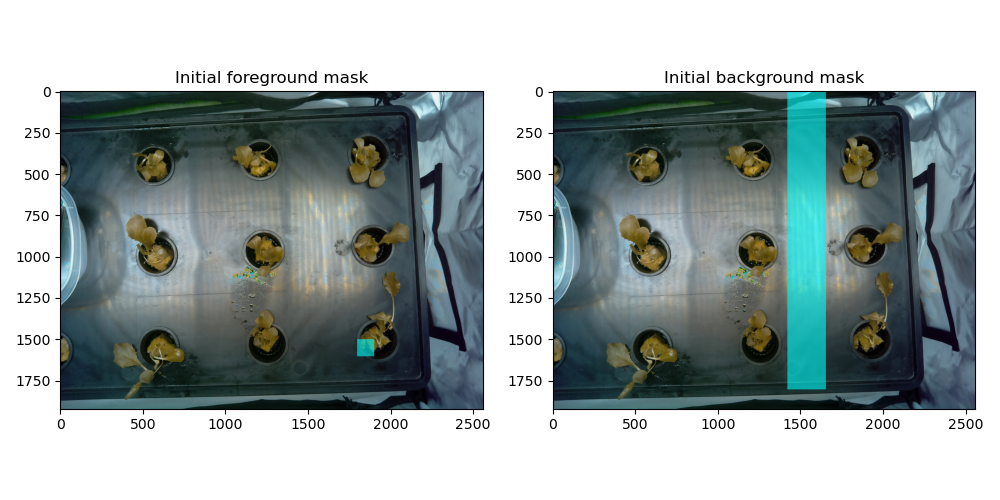

In [5]:
im = imageio.imread(ims[0])
h,w = im.shape[:2]

# Now set some rectangular region of the initial foreground mask to 1.
# This should be a part of the image that is fully foreground.
# The indices in the following line are just an example,
# and they need to be corrected so that only flower pixels are included
# init_fg_mask[10:20, 15:30] = 1

# Same for the background (replace the indices)
# init_bg_mask[60:90, 50:110] = 1

init_fg_mask = np.zeros([h, w])
init_bg_mask = np.zeros([h, w])
init_fg_mask[1500: 1600, 1800:1900] = 1
init_bg_mask[0:1800, 1420:1650] = 1


fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].set_title('Initial foreground mask')
axes[0].imshow(draw_mask_on_image(im, init_fg_mask))
axes[1].set_title('Initial background mask')
axes[1].imshow(draw_mask_on_image(im, init_bg_mask))
fig.tight_layout()

## Color Modeling by Histograms

A common way to model color distributions is to use *Gaussian mixture models*. However, to keep this exercise simple, we will only use color histograms (i.e. the relative frequencies of quantized colors) in the respective region of the image defined by the boxes. In other words, we model the color simply as a discretized, categorical random variable.

Implement the function `calculate_histogram`. It should take as input the image `img` with values in the range $[0, 255]$ and a `mask` the same size as the image. The mask is 1 at the positions of the image where the histogram should be computed, zero elsewhere. The final parameter `n_bins` defines how many bins should be used in the histogram along each dimension. The function should **return a 3-dimensional array** of shape `[n_bins, n_bins, n_bins]`, containing the relative frequency for each (r,g,b) color bin within the region of the image defined by the mask, i.e. the fraction of pixels falling within each bin. The histogram should be normalized (sum to 1). Initialize all bins with a small value ($10^{−3}$) to avoid relative frequencies which are zero (this is called *additive smoothing*). (Why would zeros be a problem?)

In [6]:
def calculate_histogram(img, mask, n_bins):
    histogram = np.full((n_bins, n_bins, n_bins), fill_value=0.001)
    
    # convert values to range of bins
    binned_im = (img.astype(np.float32)/256*n_bins).astype(int)

    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            if mask[y, x] != 0:
                histogram[binned_im[y, x, 0],
                          binned_im[y, x, 1], 
                          binned_im[y, x, 2]] += 1
                
    # normalize
    histogram /= np.sum(histogram)
    

    return histogram

In [7]:
def calculate_histograms(images, loc_masks, n_bins):
    
    combined_histogram = np.full((n_bins, n_bins, n_bins), fill_value=0.001)
    
    for image, loc_mask in zip(images, loc_masks):
        
        histogram = np.full((n_bins, n_bins, n_bins), fill_value=0.001)
        
        im = imageio.imread(image)
        h,w = im.shape[:2]
        
        init_mask = np.zeros([h, w])
        init_mask[loc_mask[0]:loc_mask[1], loc_mask[2]:loc_mask[3]] = 1
        
        # convert values to range of bins
        binned_im = (im.astype(np.float32)/256*n_bins).astype(int)

        for y in range(im.shape[0]):
            for x in range(im.shape[1]):
                if init_mask[y, x] != 0:
                    histogram[binned_im[y, x, 0],
                              binned_im[y, x, 1], 
                              binned_im[y, x, 2]] += 1
        combined_histogram += histogram
        
    # normalize
    combined_histogram /= np.sum(combined_histogram)
    

    return combined_histogram


In [8]:
n_bins = 15
fg_histogram = calculate_histograms(ims, init_fg_masks, n_bins)
bg_histogram = calculate_histograms(ims, init_bg_masks, n_bins)

<IPython.core.display.Javascript object>


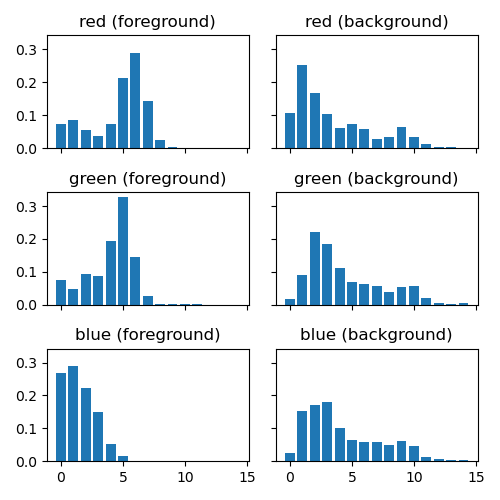

In [9]:
fig, axes = plt.subplots(
    3, 2, figsize=(5,5), sharex=True, 
    sharey=True, num='Relative frequency of color bins')

x = np.arange(n_bins)
axes[0,0].bar(x, np.sum(fg_histogram, (1, 2)))
axes[0,0].set_title('red (foreground)')
axes[1,0].bar(x, np.sum(fg_histogram, (0, 2)))
axes[1,0].set_title('green (foreground)')
axes[2,0].bar(x, np.sum(fg_histogram, (0, 1)))
axes[2,0].set_title('blue (foreground)')

axes[0,1].bar(x, np.sum(bg_histogram, (1, 2)))
axes[0,1].set_title('red (background)')
axes[1,1].bar(x, np.sum(bg_histogram, (0, 2)))
axes[1,1].set_title('green (background)')
axes[2,1].bar(x, np.sum(bg_histogram, (0, 1)))
axes[2,1].set_title('blue (background)')
fig.tight_layout()

In [10]:
# n_bins = 10
# fg_histogram = calculate_histogram(im, init_fg_mask, n_bins)
# bg_histogram = calculate_histogram(im, init_bg_mask, n_bins)

# fig, axes = plt.subplots(
#     3, 2, figsize=(5,5), sharex=True, 
#     sharey=True, num='Relative frequency of color bins')

# x = np.arange(n_bins)
# axes[0,0].bar(x, np.sum(fg_histogram, (1, 2)))
# axes[0,0].set_title('red (foreground)')
# axes[1,0].bar(x, np.sum(fg_histogram, (0, 2)))
# axes[1,0].set_title('green (foreground)')
# axes[2,0].bar(x, np.sum(fg_histogram, (0, 1)))
# axes[2,0].set_title('blue (foreground)')

# axes[0,1].bar(x, np.sum(bg_histogram, (1, 2)))
# axes[0,1].set_title('red (background)')
# axes[1,1].bar(x, np.sum(bg_histogram, (0, 2)))
# axes[1,1].set_title('green (background)')
# axes[2,1].bar(x, np.sum(bg_histogram, (0, 1)))
# axes[2,1].set_title('blue (background)')
# fig.tight_layout()

## Foreground Probability Map

The next step in the segmentation process is to estimate a probability map: For each pixel we want to estimate the probability that it belongs to the foreground. This will be used as basis for the unary potential.

The function `foreground_pmap(img, fg_histogram, bg_histogram)` should take the image `img` and the two histograms `fg_histogram`, `bg_histogram` estimated from the foreground region and the background region respecively. It should return an array of shape $\texttt{height}\times\texttt{width}$ containing the probability of each pixel belonging to the foreground. To estimate the required probability $p(c|[r, g, b])$ from the computed histograms, a class prior $p(c)$ of $0.5$ should be used, which means that both foreground and background pixels are equally likely a priori. 

Recall Bayes' theorem applied to this case:

$$
p(c\ |\ r,g,b) = \frac{p(c) \cdot p(r,g,b\ |\ c)}{p(r,g,b)} = \frac{p(c)\cdot p(r,g,b\ |\ c)}{\sum_{\tilde{c}} p(\tilde{c}) \cdot p(r,g,b\ |\ \tilde{c}) }
$$

In [10]:
def foreground_pmap(img, fg_histogram, bg_histogram):
    h, w, c = img.shape
    n_bins = len(fg_histogram)
    binned_im = (img.astype(np.float32)/256*n_bins).astype(int)
    
    # prior probabilities
    p_fg = 0.5
    p_bg = 1 - p_fg
    
    # extract fg & bg prob from histograms
    p_rgb_given_fg = fg_histogram[binned_im[:, :, 0],
                                  binned_im[:, :, 1], 
                                  binned_im[:, :, 2]]
    
    p_rgb_given_bg = bg_histogram[binned_im[:, :, 0],
                                  binned_im[:, :, 1],
                                  binned_im[:, :, 2]]
    
    p_fg_given_rgb = (p_fg * p_rgb_given_fg /
                      (p_fg * p_rgb_given_fg + p_bg * p_rgb_given_bg))
    return p_fg_given_rgb


### Filtering

In [12]:
# im = cv2.medianBlur(im,5)
# grayimg = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)
# circles = cv2.HoughCircles(grayimg,cv2.HOUGH_GRADIENT,1,20,
#                             param1=150,param2=40,minRadius=100,maxRadius=120)
# circles = np.uint16(np.around(circles))
# cimg = im.copy()
# for i in circles[0,:]:
#     # draw the outer circle
#     cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
#     # draw the center of the circle
#     cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),30)
    

In [13]:
# cropped_images = []
# for value in circles[0,:]:

#     distance = int(2*value[2])
#     cropped_image = im[value[1]-distance:value[1]+distance, value[0]-distance:value[0]+distance, :]
#     cropped_images.append(cropped_image)

In [14]:
# %matplotlib inline
# plt.imshow(cropped_images[3])
# plt.show()

In [15]:
# im = cropped_image

In [17]:
# fig, axes = plt.subplots(1, 2, figsize=(10,5), sharey=True)
# axes[0].imshow(im)
# axes[0].set_title('Input image')
# im_plot = axes[1].imshow(cimg, cmap='viridis')
# axes[1].set_title('Detected circles')
# fig.tight_layout()
# fig.colorbar(im_plot, ax=axes)

<IPython.core.display.Javascript object>


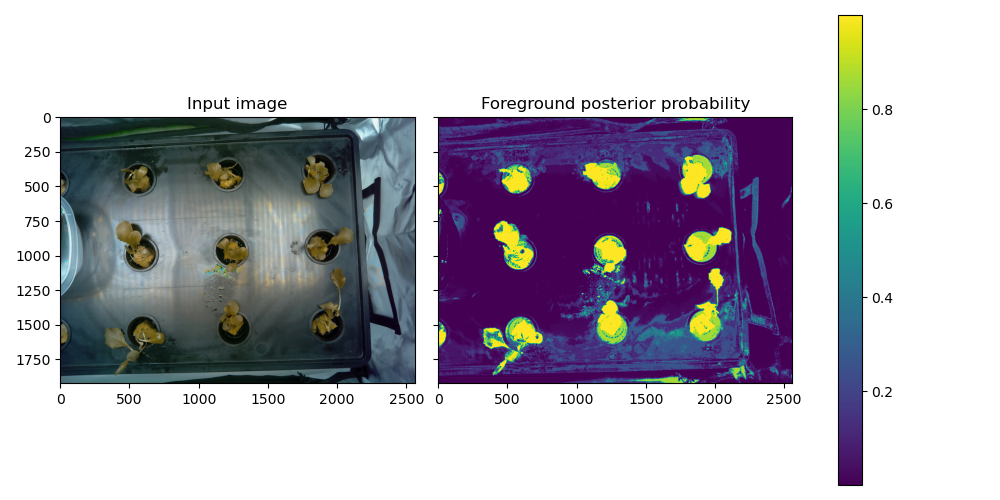

In [11]:
foreground_prob = foreground_pmap(im, fg_histogram, bg_histogram)
fig, axes = plt.subplots(1, 2, figsize=(10,5), sharey=True)
axes[0].imshow(im)
axes[0].set_title('Input image')
im_plot = axes[1].imshow(foreground_prob, cmap='viridis')
axes[1].set_title('Foreground posterior probability')
fig.tight_layout()
fig.colorbar(im_plot, ax=axes)
foreground_map = (foreground_prob > 0.5)

## Unary Potentials
Use the previously computed probability map `foreground_map` to compute the unary potential for both foreground and background.

This function `unary_potentials(probability_map, unary_weight)` shall use the `probability_map` and a scalar weighting factor to compute the unary potentials. It should return a matrix of the same size as the probability matrix.

<IPython.core.display.Javascript object>


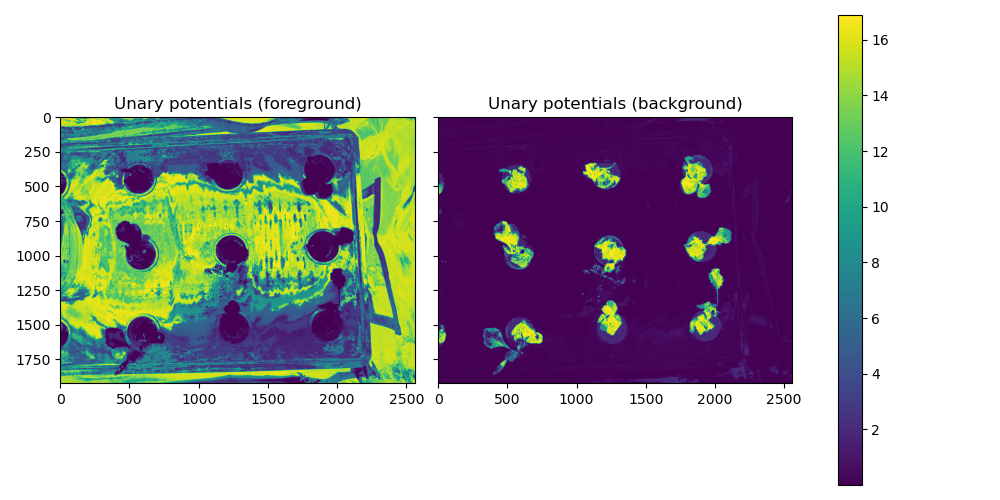

In [12]:
%matplotlib notebook
def unary_potentials(probability_map, unary_weight):
    return -unary_weight * np.log(probability_map)

    
unary_weight = 1
unary_fg = unary_potentials(foreground_prob, unary_weight)
unary_bg = unary_potentials(1 - foreground_prob, unary_weight)
fig, axes = plt.subplots(1, 2, figsize=(10,5), sharey=True)
axes[0].imshow(unary_fg)
axes[0].set_title('Unary potentials (foreground)')
im_plot = axes[1].imshow(unary_bg)
axes[1].set_title('Unary potentials (background)')
fig.tight_layout()
fig.colorbar(im_plot, ax=axes)

## Pairwise Potentials

Create a function to compute the prefactor $w_p$ of the pairwise potential for two specific pixels. Implement the funtion below, where `img` is the image, `(x1, y1), (x2, y2)` are the pixel coordinates in the image and the last parameter is the weight $\omega_p$ for the pairwise potential. (Do not confuse `(x1, y1), (x2, y2)` with the $X_j, Y_j$ from the top of the page. There X was the label and Y the pixel value, here they are the x and y coordinates in the image) 

Keep in mind that this prefactor does not depend on the labels and is therefore independent of $\mathcal{X}$.

Also, the function signature is more general (see the contrast-sensitive Potts Model question later on), not all parameters are needed here.

In [13]:
def pairwise_potential_prefactor(img, x1, y1, x2, y2, pairwise_weight):
    return pairwise_weight #* np.exp(-1e-1*np.sum((img[y1,x1]-img[y2,x2])**2))


Using the functions from the previous task, implement a function to compute all the pairwise potentials for the image using 4-neighborhoods. That means only the top, bottom, left and right neighboring pixels should be connected to a given pixel.

The function `pairwise_potentials` should return the `edges` (represented as index pairs) and an array `costs` containing the corresponding edge costs (i.e. the value of the pairwise potential prefactor). Note that you have to use a linearized index instead of (x,y)-coordinates. A conversion function is supplied (`coords_to_index(x, y, width)`).

Again, `edges` should be an integer array of shape $k\times 2$, while `costs` should have length $k$, where $k$ is the number of neighborhood-edges in the image grid.

In [14]:
def coords_to_index(x, y, width):
    return y * width + x

def pairwise_potentials(im, pairwise_weight):
    edges = []
    costs = []

    im = im.astype(np.float32)/255
    h, w = im.shape[:2]
    
    for y in range(h):
        for x in range(w):
            # Neighbor coordinates
            xs_neigh = x + np.array([0, 1, 0, -1])
            ys_neigh = y + np.array([-1, 0, 1, 0])
            
            # Make sure neighbors are within image
            mask = np.logical_and(
                np.logical_and(xs_neigh >= 0, xs_neigh < w),
                np.logical_and(ys_neigh >= 0, ys_neigh < h))
            xs_neigh = xs_neigh[mask]
            ys_neigh = ys_neigh[mask]
            
            center_index = coords_to_index(x, y, w)
            for x_neigh, y_neigh in zip(xs_neigh, ys_neigh):
                cost = pairwise_potential_prefactor(
                    im, x, y, x_neigh, y_neigh, pairwise_weight)
                neighbor_index = coords_to_index(x_neigh, y_neigh, w)
                edges.append((center_index, neighbor_index))
                costs.append(cost)
                
    edges = np.array(edges)
    costs = np.array(costs)

    return edges, costs

pairwise_edges, pairwise_costs = pairwise_potentials(im, pairwise_weight=.1)

In [22]:
from pyGCO_master.pyGCO_master.gco import pygco

def graph_cut(unary_fg, unary_bg, pairwise_edges, pairwise_costs):
    unaries = np.stack([unary_bg.flat, unary_fg.flat], axis=-1)
    labels = pygco.cut_general_graph(
        pairwise_edges, pairwise_costs, unaries, 
        1-np.eye(2), n_iter=-1, algorithm='expansion',down_weight_factor=20)
    return labels.reshape(unary_fg.shape)


graph_cut_result = graph_cut(unary_fg, unary_bg, pairwise_edges, pairwise_costs)


<IPython.core.display.Javascript object>


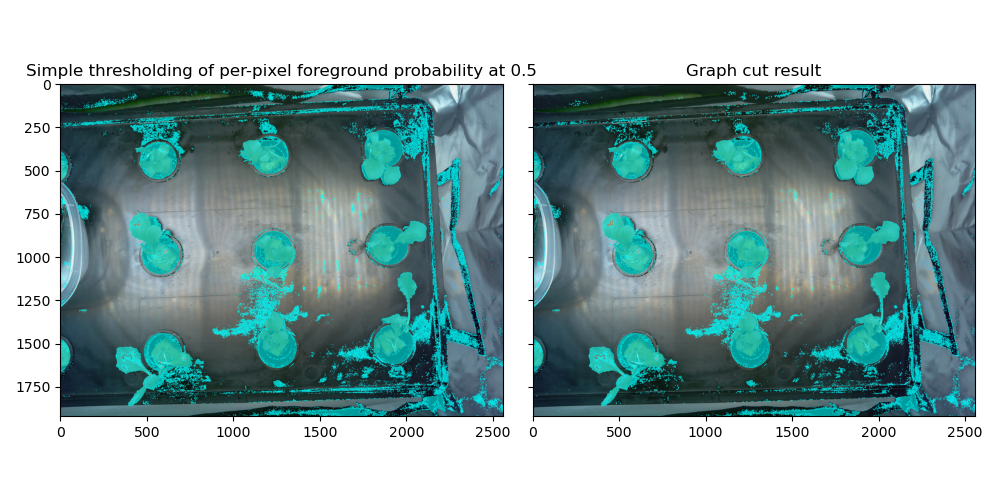

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(10,5), sharey=True)
axes[0].set_title('Simple thresholding of per-pixel foreground probability at 0.5')
axes[0].imshow(draw_mask_on_image(im, foreground_prob>.5))
axes[1].set_title('Graph cut result')
axes[1].imshow(draw_mask_on_image(im, graph_cut_result))
fig.tight_layout()

## Iterative Segmentation

We can make the result better if we iterate the labeling process several times. Implement `iterative_opt`, a method to execute the optimization process iteratively. 

Use the previously computed labeling as initial segmentation (instead of the rectangular masks we used above) and estimate new models (histograms and unaries) for foreground and background based on these. Solve the graph cut problem and use the resulting segmentation in the next iteration.

In [ ]:
def iterative_opt(img, fg_mask, n_bins, unary_weight,
                  pairwise_edges, pairwise_costs, n_iter):

    h, w, c = img.shape
    for i in range(n_iter):
        # recalculate histograms based on new masks
        fg_histogram = calculate_histogram(img, fg_mask, n_bins)
        bg_histogram = calculate_histogram(img, 1-fg_mask, n_bins)

        foreground_probability = foreground_pmap(img, fg_histogram, bg_histogram)
        unary_fg = unary_potentials(foreground_probability, unary_weight)
        unary_bg = unary_potentials(1 - foreground_probability, unary_weight)
        fg_mask = graph_cut(unary_fg, unary_bg, pairwise_edges, pairwise_costs)
    return fg_mask


labels_5 = iterative_opt(
    im, graph_cut_result, n_bins, unary_weight, pairwise_edges, pairwise_costs, n_iter=5)
labels_10 = iterative_opt(
    im, labels_5, n_bins, unary_weight, pairwise_edges, pairwise_costs, n_iter=5)



In [ ]:
graph_cut_result = cv2.bilateralFilter(graph_cut_result.astype(np.int8),9,75,75)

In [ ]:
graph_cut_result = cv2.fastNlMeansDenoising(graph_cut_result.astype(np.int8)255)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12,4), sharex=True, sharey=True)
axes[0].set_title('Initial')
axes[0].imshow(draw_mask_on_image(im, graph_cut_result))
axes[1].set_title(f'After 5 iterations')
axes[1].imshow(draw_mask_on_image(im, labels_5))
axes[2].set_title(f'After 10 iterations')
axes[2].imshow(draw_mask_on_image(im, labels_10))
fig.tight_layout()

In [ ]:
%matplotlib notebook
plt.imshow(labels_10)
plt.show()

In [ ]:
# Find Canny edges
edged = cv2.Canny(im, 190, 240)
plt.imshow(edged)
  

In [ ]:
# Finding Contours
# Use a copy of the image e.g. edged.copy()
# since findContours alters the image
contours, hierarchy = cv2.findContours(edged, 
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
drawing = np.zeros(im.shape[:2])
cv2.drawContours(drawing, contours, -1, 255, 3)
plt.imshow(drawing)

In [ ]:
area = 0
filtered_contours = []
for contour in contours:
    c_area = cv2.contourArea(contour)
    if c_area>300:
        area += c_area
        filtered_contours.append(contour)

In [ ]:
drawing2 = np.zeros(im.shape[:2])
cv2.drawContours(drawing2, filtered_contours, -1, 255, 3)
plt.imshow(drawing2)